In [1]:
import pandas as pd
from datetime import datetime

In [2]:
order_sales_data = pd.read_excel("Order_sales_Data.xlsx")
wallet_transaction_data = pd.read_excel("Wallet_Transaction_Data.xlsx")

In [4]:
order_sales_data['DELIVERY_DATE'] = pd.to_datetime(order_sales_data['DELIVERY_DATE'])
order_sales_data['DELIVERY_TIME'] = pd.to_datetime(order_sales_data['DELIVERY_TIME'], format='%H:%M:%S')

wallet_transaction_data['TRANSACTION_DATE'] = pd.to_datetime(wallet_transaction_data['TRANSACTION_DATE'])
wallet_transaction_data['TRANSACTION_TIME'] = pd.to_datetime(wallet_transaction_data['TRANSACTION_TIME'])

order_sales_data['DELIVERY_DATETIME'] = order_sales_data['DELIVERY_DATE'] + pd.to_timedelta(order_sales_data['DELIVERY_TIME'].dt.strftime('%H:%M:%S'))
wallet_transaction_data['TRANSACTION_DATETIME'] = wallet_transaction_data['TRANSACTION_DATE'] + pd.to_timedelta(wallet_transaction_data['TRANSACTION_TIME'].dt.strftime('%H:%M:%S'))

C:\Users\user\AppData\Local\Temp\ipykernel_13884\333912811.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  wallet_transaction_data['TRANSACTION_TIME'] = pd.to_datetime(wallet_transaction_data['TRANSACTION_TIME'])


In [5]:
last_transaction_date = wallet_transaction_data.groupby('CUSTOMER_ID')['TRANSACTION_DATE'].max()
last_transaction_date = datetime.now() - last_transaction_date
recency = last_transaction_date.dt.days

In [6]:
frequency = wallet_transaction_data.groupby('CUSTOMER_ID').size()

In [7]:
monetary = wallet_transaction_data.groupby('CUSTOMER_ID')['AMOUNT'].sum()

In [8]:
rfm_table = pd.DataFrame({'Recency': recency, 'Frequency': frequency, 'Monetary': monetary})

In [9]:
def assign_quartile(x, q):
    if x <= q[0.25]:
        return 1
    elif x <= q[0.50]:
        return 2
    elif x <= q[0.75]:
        return 3
    else:
        return 4

In [10]:
quartiles = rfm_table.quantile(q=[0.25, 0.5, 0.75])

In [11]:
rfm_table['R'] = rfm_table['Recency'].apply(assign_quartile, args=(quartiles['Recency'],))
rfm_table['F'] = rfm_table['Frequency'].apply(assign_quartile, args=(quartiles['Frequency'],))
rfm_table['M'] = rfm_table['Monetary'].apply(assign_quartile, args=(quartiles['Monetary'],))

In [12]:
rfm_table['RFM_Segment'] = rfm_table['R'].map(str) + rfm_table['F'].map(str) + rfm_table['M'].map(str)

In [13]:
rfm_table['RFM_Score'] = rfm_table[['R', 'F', 'M']].sum(axis=1)

In [14]:
rfm_table.to_excel("rfm_analysis_result.xlsx", index=True)

In [15]:
print(rfm_table)

             Recency  Frequency  Monetary  R  F  M RFM_Segment  RFM_Score
CUSTOMER_ID                                                              
8                 98         27    1720.0  4  2  1         421          7
20                53          7     470.0  3  1  1         311          5
43                47         12     860.0  3  1  1         311          5
50                18        192   17440.0  1  4  4         144          9
51                31         59    7040.0  3  2  3         323          8
...              ...        ...       ... .. .. ..         ...        ...
13636             20          2    3000.0  2  1  1         211          4
13637             20          2    1400.0  2  1  1         211          4
13641             20          2    1499.0  2  1  1         211          4
13647             18          4    1629.0  1  1  1         111          3
13648             19          2    1400.0  2  1  1         211          4

[3935 rows x 8 columns]


In [16]:
import matplotlib.pyplot as plt

In [17]:
rfm_table = pd.read_excel("rfm_analysis_result.xlsx")

In [18]:
segments = {
    'Standard': (0, 5),
    'Moderate': (5, 10),
    'Premium': (10, 15)
}

In [19]:
def assign_segment(score):
    for segment, (lower, upper) in segments.items():
        if lower <= score < upper:
            return segment

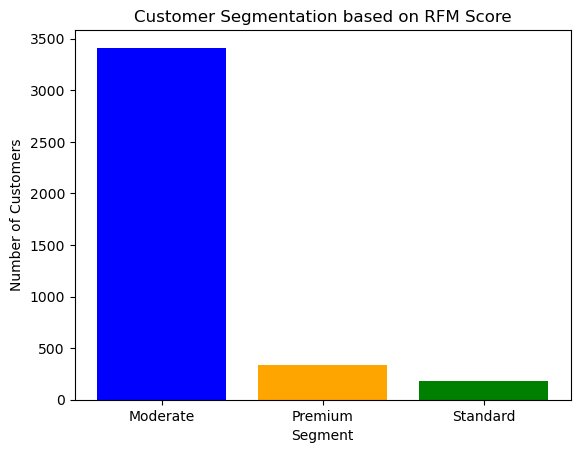

In [20]:
rfm_table['Segment'] = rfm_table['RFM_Score'].apply(assign_segment)
segment_counts = rfm_table['Segment'].value_counts()
plt.bar(segment_counts.index, segment_counts.values, color=['blue', 'orange', 'green'])
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.title('Customer Segmentation based on RFM Score')
plt.savefig('customer_segmentation_curve.png')
plt.show()

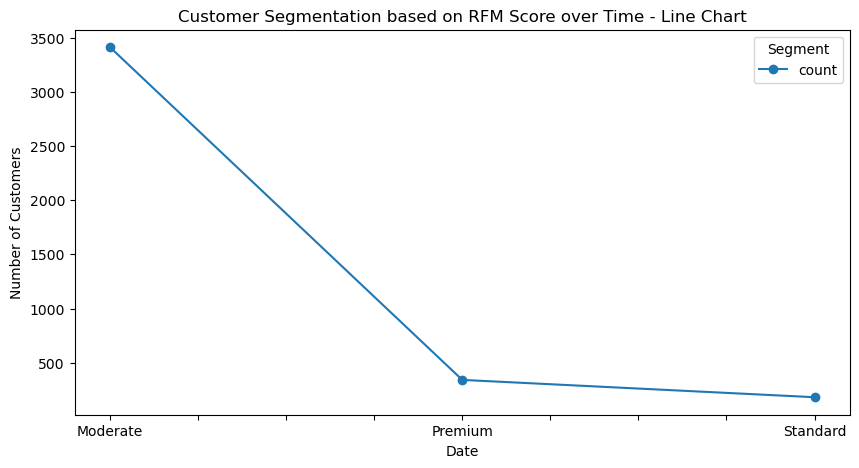

In [21]:
plt.figure(figsize=(10, 5))
segment_counts.plot(kind='line', marker='o')
plt.xlabel('Date')
plt.ylabel('Number of Customers')
plt.title('Customer Segmentation based on RFM Score over Time - Line Chart')
plt.legend(title='Segment')
plt.savefig('Customer Segmentation based on RFM Score over Time - Line Chart')

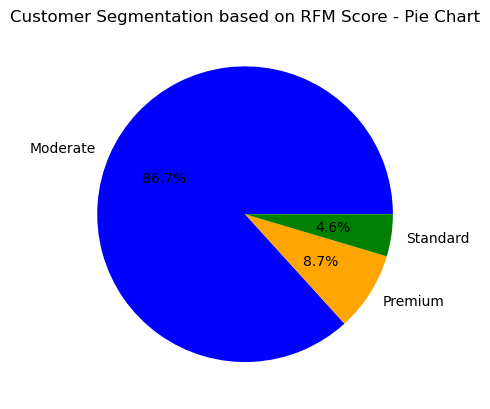

In [22]:
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', colors=['blue', 'orange', 'green'])
plt.title('Customer Segmentation based on RFM Score - Pie Chart')
plt.savefig('Customer Segmentation based on RFM Score - Pie Chart')

In [23]:
print("Segment Counts:")
print(segment_counts)

Segment Counts:
Segment
Moderate    3413
Premium      341
Standard     181
Name: count, dtype: int64


In [34]:
import seaborn as sns
import numpy as np
import datetime as dt
from textwrap import wrap

In [61]:
wallet_transaction_data['TRANSACTION_MONTH'] = wallet_transaction_data['TRANSACTION_DATE'].apply(lambda x: dt.datetime(x.year, x.month, 1))
wallet_transaction_data['CohortMonth'] = wallet_transaction_data.groupby('CUSTOMER_ID')['TRANSACTION_MONTH'].transform('min')

In [62]:
wallet_transaction_data['CohortIndex'] = ((wallet_transaction_data['TRANSACTION_MONTH'].dt.year - wallet_transaction_data['CohortMonth'].dt.year) * 12 + (wallet_transaction_data['TRANSACTION_MONTH'].dt.month - wallet_transaction_data['CohortMonth'].dt.month) + 1)

In [63]:
cohort_data = wallet_transaction_data.groupby(['CohortMonth', 'CohortIndex']).agg({'CUSTOMER_ID': 'nunique'}).reset_index()

In [64]:
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CUSTOMER_ID')

In [65]:
cohort_sizes = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

In [66]:
retention.index = retention.index.strftime('%Y-%m')

In [67]:
retention_percentage = retention * 100

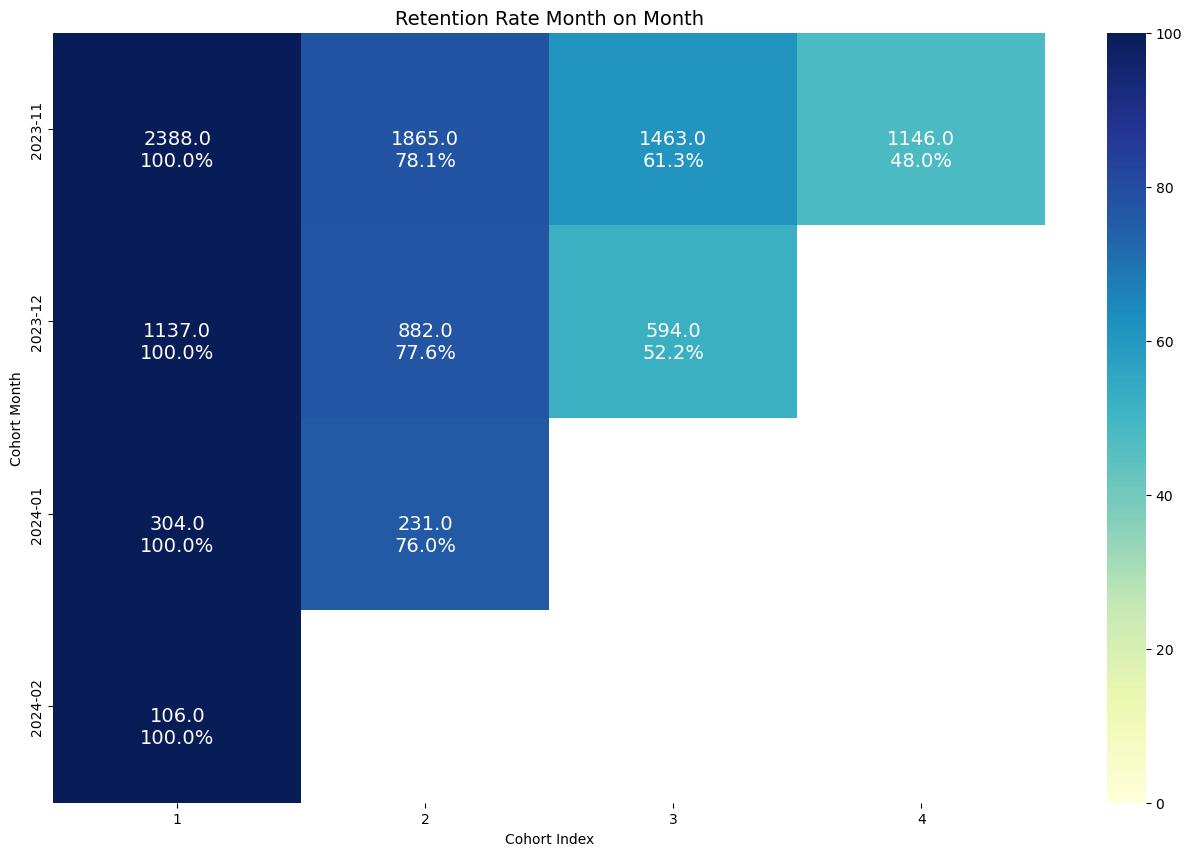

In [96]:
plt.figure(figsize=(16, 10))
plt.title('Retention Rate Month on Month', fontsize=14)
sns.heatmap(retention_percentage, annot=False, vmin=0.0, vmax=100, cmap="YlGnBu", fmt='.1f')
for i in range(retention_percentage.shape[0]):
    for j in range(retention_percentage.shape[1]):
        count = cohort_counts.iloc[i, j]
        plt.text(j + 0.5, i + 0.5, '{}\n{:.1f}%'.format(count, retention_percentage.iloc[i, j]), horizontalalignment='center', verticalalignment='top', fontsize=14, color = 'white')
plt.ylabel('Cohort Month')
plt.xlabel('Cohort Index')
plt.yticks(rotation='vertical')
plt.savefig('Retention Rate Month on Month')
plt.show()